# AI - Keras Neural Network

La spécificité de keras est quelle utilise TensorFlow et Theano comme "engine". Cette librairie permet de se concentrer sur l'aspect design et training et les specificités liées au tensor sont laissé à tensorflow et theano.

# Import

In [21]:
import  numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import SVG

from keras import models
from keras import layers
from keras.datasets import imdb, reuters, mnist
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.vis_utils import model_to_dot
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing


# Sommaire

[I. Designing a neural network](#Partie1)

[II. Training a binary and multiclass classifier](#Partie2)
- [II.1. Binary](#Partie2.1) 
- [II.2. Multiclass](#Partie2.2) 

[III. Training a regressor](#Partie3)

[IV. Visualizing training and making predictions](#Partie4)
- [IV.1. Visualizing training](#Partie4.1) 
- [IV.2. Making predictions](#Partie4.2) 

[V. Reduce overfitting](#Partie5)
- [V.1. With weight regularization](#Partie5.1) 
- [V.2. With early stopping](#Partie5.2)
- [V.3. With dropout](#Partie5.3) 

[VI. k-fold cross-validation and tunning a neural network](#Partie6)
- [VI.1. K-fold cross validation](#Partie6.1) 
- [VI.2. Tuning neural networks](#Partie6.2)

[VII. Visualizing neural networks](#Partie7)

[VIII. Classifying images](#Partie8)
- [VIII.1. Image classification](#Partie8.1) 
- [VIII.2. Improving performance with image augmentation](#Partie8.2)

[IX. Classifying text](#Partie9)

[X. Saving & loading a model](#Partie10)

## I. Designing a neural network<a class="anchor" id="Partie1"></a>

Tout d'abord les données sont preprocessées selon leur type (si numérique alors on utilise standardscaler)

Les reseaux de neurones consistent en des couches d'unité (neurone). Pour construire ici un reseau feed forward on doit faire plusieurs choix pour l'architecture et le processus d'entrainement. Il faut tout d'abord se rappeler que chaque unit (ie neurone) recoit :
- un certain nombe d'inputs
- toutes les inputs sont pondérés par un paramètre
- on fait la combinaison linéaire de toutes les inputs pondérés et d'un biais (1 en général)
- on y applique ensuite une fonction d'activation
- on envoie l'output a la couche suivante

1/ De manière générale: plus il y a de neurones sur une couche plus le reseau sera capable d'apprendre des pattern complexes mais plus le reseau est susceptible de surappendre. On doit d'abord chosir la fonction d'activation (relu est un bon choix si la somme pondérée est inférieur à 0 alors la fonction renvoie 0 sinon elle renvoie la somme)

2/ On doit ensuite définir le nombre de couche cachée à ajouter à l'architecture. Plus il y a de couche plus le reseau peut appendre des relations complexes mais avec un coût sur la complexité.
 
3/On doit ensuite définir la couche d'activation pour la dernière couche. Cela depend du but du reseau:
- pour une classification binaire on utilisera sigmoide
- pour une classifcation multiclass on utilisera softmax
- pour une regression on utilisera pas d'activation (ie linéaire)

4/ Dans un 4eme temps on définit la loss function (qui mesure à quel point les valeurs prédites sont poches des vrais valeurs)
- binary classification: binary cross entropy
- multiclass classification: categorical cross entropy
- regression: mse

5/ On définit ensuite "l'optimizer" qui est note stratégie pour trouver les meilleurs paramètres pou poduire une loss minimale. les choix communs sont: stochastic gradient descent, with momentum, rms propagation, adaptative moment...

6/ On selectionne les metriques de performance de notre algorithme.

Keras permet de construire un reseau avec sequential qui va juxtaposer chaque couche. Dans notre reseau on a crée un reseau à 2 couches (on ne compte pas la couche d'entrée car elle n'a pas de poid). Les couches sont "dense" (qui correspond à des couches fully connected ie tous les neurones de la couche précédente sont connectés au neurones de la couche suivante). Units=16 signifie qu'il y a 16 neurones sur la couche. Dans Keras la première couche cachée doti comporter l'argument "input_shape" qui est la dimension des features (ie leur nombre). (10,) signifie que chaque observation a 10 features. ici on a designé un reseau pour une classification binaire donc il y a une seule sortie avec activation sigmoide qui sera entre 0 et 1 qui correspond à la probabilité d'obtenir la classe 1.

In [2]:
network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(10,))) #ajout d'une fully connected layer avec Relu
network.add(layers.Dense(units=16,activation="relu")) #ajout d'une fully connected layer avec Relu
network.add(layers.Dense(units=1,activation="sigmoid")) #ajout d'une fully connected layer avec sigmoide

network.compile(loss="binary_crossentropy", # loss de cross entropy pour pb de classification
                optimizer="rmsprop", # propagation avec root mean square 
                metrics=["accuracy"]) #accuracy comme metrique de performance

## II. Training a binary and multiclass classifier<a class="anchor" id="Partie2"></a>

### II.1. Binary<a class="anchor" id="Partie2.1"></a>

Dans cet entrainement d'un modele de classification binaire on utilise les données: de movie review (text) qui sont catégorisées en bonne (1) ou mauvaise (0). On convertit les reviews en 5000 features binaire qui indique ou non la présence des 1000 mots les plus fréquents (en one-hot encoder: si mot existe 1 sinon 0). Ces one hot vecteurs correspondent au set de train et test avec leur label correspondant.

On utilise la fonction fit de Keras pour entrainer le modèle:
- 2 premiers paramètres: features et target vecteurs du set de train
- paramètre epoch: nombre d'itération de train sur tout le set de train (ie tous les batchs)
- verbose 0,1,2 : donne des informations plus ou moins détaillé sur les epochs
- batch_size: taille des batchs pendant les epoch
- test data

La méthode fit de Keras renvoie un object qui contient les valeurs de loss et les metriques de performance demandées

In [3]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu"))
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=3, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data



Epoch 1/3
250/250 [==============================] - 2s 5ms/step - loss: 0.4247 - accuracy: 0.8104 - val_loss: 0.3370 - val_accuracy: 0.8578
Epoch 2/3
250/250 [==============================] - 1s 4ms/step - loss: 0.3261 - accuracy: 0.8638 - val_loss: 0.3490 - val_accuracy: 0.8503
Epoch 3/3
250/250 [==============================] - 1s 4ms/step - loss: 0.3156 - accuracy: 0.8687 - val_loss: 0.3269 - val_accuracy: 0.8612


### II.2. Multiclass<a class="anchor" id="Partie2.2"></a>

La différence entre le classifier ci-dessus et dessous est la catégorisation en 46 classe plutôt que une classe 0 et une classe 1 il doit donc y avoir 46 noeuds sur la dernière couche par rapport à un noeud sur la première. Le vecteur de target doit donc également être encodé en one-hot, c'est à dire chaque ligne de ces matrices contient 46 élements avec des 0 partout sauf au numéro de la classe correspondante.
Un élément important à prendre en compte est l'utilisation de la fonction d'activation softmax sur la dernière couche qui va permettre d'avoir une somme des issues égale à 1 (correspondant donc au probabilité d'occurence de chaque classe).

In [4]:
np.random.seed(0) #on confidure la random seed
number_of_features=5000 #nombre de features dans le set

#on utilise le set reuters pour créer le set de train et test
data=reuters.load_data(num_words=number_of_features) 
(data_train,target_train),(data_test,target_test)=data

# On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 5000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

# on one-hot encode le vecteur de target
target_train=to_categorical(target_train)
target_test=to_categorical(target_test)


network=models.Sequential() #start neural network

network.add(layers.Dense(units=100,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=100,activation="relu"))
network.add(layers.Dense(units=46,activation="softmax")) #units = nombre de classe dans le set

network.compile(loss="categorical_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=3, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data

Epoch 1/3
90/90 [==============================] - 2s 16ms/step - loss: 1.5288 - accuracy: 0.6627 - val_loss: 1.1213 - val_accuracy: 0.7422
Epoch 2/3
90/90 [==============================] - 1s 13ms/step - loss: 0.7980 - accuracy: 0.8211 - val_loss: 0.9409 - val_accuracy: 0.7872
Epoch 3/3
90/90 [==============================] - 1s 13ms/step - loss: 0.5101 - accuracy: 0.8927 - val_loss: 0.8748 - val_accuracy: 0.7974


## III. Training a regressor<a class="anchor" id="Partie3"></a>

Dans les cas précédents nous appliquions des fonctions activation sur la dernière couche. Dans le cas d'une regression on utilise une activation "linéaire" c'est à dire on utilise pas de fonction d'activation on renvoie directement le résultat de la combinaison linéaire de la dernière couche de neurones. On utilise ici une loss approriée comme la mse ou la mae selon la distribution des valeurs et notamment des anomalies pour leur donner plus ou moins de poid..

In [5]:
np.random.seed(0) #on confidure la random seed

#on génere les matrices de features et de target
features,target=make_regression(n_samples=10000,
                                n_features=3,
                                n_informative=3,
                                n_targets=1,
                                noise=0,
                                random_state=0)

# On divise notre matrice et nos targets en train et test
features_train, features_test, target_train,target_test=train_test_split(features, target, test_size=0.33, random_state=0)

network=models.Sequential() #start neural network

network.add(layers.Dense(units=32,activation="relu",input_shape=(features_train.shape[1],))) 
network.add(layers.Dense(units=32,activation="relu"))
network.add(layers.Dense(units=1))

network.compile(loss="mse", 
                optimizer="RMSprop", 
                metrics=["mse"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=50, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data




Epoch 1/50
67/67 [==============================] - 1s 5ms/step - loss: 17283.7715 - mse: 17283.7715 - val_loss: 17622.2363 - val_mse: 17622.2363
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 16387.2734 - mse: 16387.2734 - val_loss: 16313.6318 - val_mse: 16313.6318
Epoch 3/50
67/67 [==============================] - 0s 2ms/step - loss: 14727.8926 - mse: 14727.8926 - val_loss: 14159.8477 - val_mse: 14159.8477
Epoch 4/50
67/67 [==============================] - 0s 2ms/step - loss: 12265.2920 - mse: 12265.2920 - val_loss: 11216.7344 - val_mse: 11216.7344
Epoch 5/50
67/67 [==============================] - 0s 2ms/step - loss: 9179.9346 - mse: 9179.9346 - val_loss: 7859.4199 - val_mse: 7859.4199
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 5942.0479 - mse: 5942.0479 - val_loss: 4629.0483 - val_mse: 4629.0483
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 3283.6599 - mse: 3283.6599 - val_loss: 2389.8352 - val_mse: 

## IV. Visualizing training and making predictions<a class="anchor" id="Partie4"></a>

In [6]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu"))
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=30, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data



Epoch 1/30
250/250 [==============================] - 2s 4ms/step - loss: 0.4137 - accuracy: 0.8180 - val_loss: 0.3345 - val_accuracy: 0.8578
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3244 - accuracy: 0.8631 - val_loss: 0.3332 - val_accuracy: 0.8574
Epoch 3/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3147 - accuracy: 0.8682 - val_loss: 0.3287 - val_accuracy: 0.8595
Epoch 4/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3069 - accuracy: 0.8707 - val_loss: 0.3361 - val_accuracy: 0.8550
Epoch 5/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2991 - accuracy: 0.8743 - val_loss: 0.3294 - val_accuracy: 0.8578
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2892 - accuracy: 0.8771 - val_loss: 0.3247 - val_accuracy: 0.8600
Epoch 7/30
250/250 [==============================] - 1s 4ms/step - loss: 0.2788 - accuracy: 0.8828 - val_loss: 0.3279 - val_accuracy: 0.8580
Epoch 

### IV.1. Visualizing training<a class="anchor" id="Partie4.1"></a>

Pendant l'entrainement du resueau de neurones les 2 erreurs de test et de train vont diminuer. Mais à un certain point le réseau va sur-apprendre le set de train et se se "rémorer" celui-ci. C'est alors que l'on voit une divergence de croissance entre l'erreur de training et celle de test.  Il faut donc arreter l'entrainement avant cet instant là pour avoir une erreur de validation minmale.

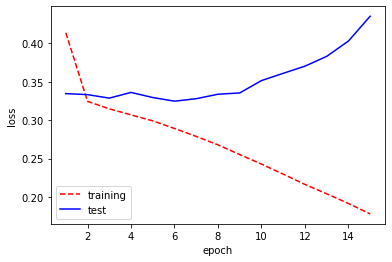

In [7]:
# on recupère la loss de training et de validation et le nombre d'epoch
training_loss=history.history["loss"]
test_loss=history.history["val_loss"]
epoch_count=range(1,len(training_loss)+1)

# visualisation de la loss
plt.plot(epoch_count[:15],training_loss[:15],"r--")
plt.plot(epoch_count[:15],test_loss[:15],"b-")
plt.legend(["training","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

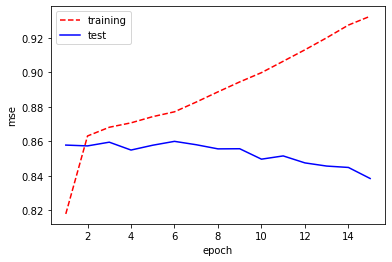

In [8]:
training_acc=history.history["accuracy"]
test_acc=history.history["val_accuracy"]

# visualisation de l'accuracy
plt.plot(epoch_count[:15],training_acc[:15],"r--")
plt.plot(epoch_count[:15],test_acc[:15],"b-")
plt.legend(["training","test"])
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

### IV.2. Making predictions<a class="anchor" id="Partie4.2"></a>

Une fois le réseau entrainé on utilise la fonction predict pour prédire de nouvelle valeur avec le reseau. si le reseau prédit l'issu d'une classification binaire (notre cas) le résultat est la probabilité d'obtenir 1. Si c'est une multiclassification on a alors la probabilité de toutes les classes et on peut obtenir la classe avec la probabilité maximum en utilisant la fonction argmax. Enfin si c'est une régression on va avoir la valeur réelle prédite.

In [9]:
predicted_target=network.predict(features_test)
predicted_target[4]

array([0.9999884], dtype=float32)

## V. Reduce overfitting<a class="anchor" id="Partie5"></a>

### V.1. With weight regularization<a class="anchor" id="Partie5.1"></a>

Ici on va réentrainer un classifieur binaire en utilisant une régularisation en "pénalisant" les paramètres (ie les poids les neurones) de sorte à ce qu'ils soient forcés à être des petites valeurs (ce qui conduit à un modèle plus simple et donc moins susceptible d'overfit). On force les poids à être plus petit car lors du calcul du gradient on ne va plus seulement soustraire le learning rate * dloss mais on va également soustraire 2 * lambda * w 

Cette méthode s'appelle le Weight Decay/Regularization. Cela consiste à rajouter à la loss la norme L2 des poids à chaque couche (ie la somme de chaque poid au carré pour chaque couche de neurones) multiplié par un coefficient (ici 0.01).

In [10]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",kernel_regularizer=regularizers.l2(0.01),input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu",kernel_regularizer=regularizers.l2(0.01)))
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=30, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data



Epoch 1/30
250/250 [==============================] - 2s 4ms/step - loss: 0.6458 - accuracy: 0.7991 - val_loss: 0.5006 - val_accuracy: 0.8435
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.4638 - accuracy: 0.8535 - val_loss: 0.4596 - val_accuracy: 0.8484
Epoch 3/30
250/250 [==============================] - 1s 4ms/step - loss: 0.4379 - accuracy: 0.8542 - val_loss: 0.4520 - val_accuracy: 0.8426
Epoch 4/30
250/250 [==============================] - 1s 4ms/step - loss: 0.4214 - accuracy: 0.8586 - val_loss: 0.4395 - val_accuracy: 0.8438
Epoch 5/30
250/250 [==============================] - 1s 4ms/step - loss: 0.4116 - accuracy: 0.8568 - val_loss: 0.4235 - val_accuracy: 0.8484
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 0.4055 - accuracy: 0.8604 - val_loss: 0.4373 - val_accuracy: 0.8380
Epoch 7/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3978 - accuracy: 0.8616 - val_loss: 0.3960 - val_accuracy: 0.8593
Epoch 

### V.2. With early stopping<a class="anchor" id="Partie5.2"></a>

On va maintenant réduire l'overfitting en arrêtant l'entraînement lorsque la loss du set de test arrête de décroître cela est appelé le: early stopping. De même on va réentrainer un classifieur binaire.

En effet au bout d'un certain nombre d'epoch le réseau va "mémoriser" le set de train donc l'érreur sur le train va continuer à décroître mais celle de test va augmenter c'est pourquoi une des meilleurs méthodes est d'arreter l'entraînement du réseau quand l'erreur de test commence à augmenter. On utilise donc les callbacks qui vont être des fonctions qui vont s'appliquer à la fin de chaque epoch. Ici on applique early stopping et avec le paramètre patience au bout de 2 epochs où la loss de test a augmenter l'entraînement s'arrète. On doit rajouter SaveMyCheckpoint comme fonction callback pour bien enregistrer le meilleur modèle et donc pas le modèle après les 2 epochs où la loss de test va augmenter.

In [11]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu"))
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# On fixe les fonctions de callbacks qui vont permettre le early stopping 
# (ici on arrete au bout de 2 epoch quand la loss de validation n'a pas augmenté et on sauvegarde le meilleur modèle)

callbacks=[EarlyStopping(monitor="val_loss",patience=2),
            ModelCheckpoint(filepath="best_model.h5",monitor="val_loss",save_best_only=True)]

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=30, #nombre d'epoch
                    callbacks=callbacks,
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data



Epoch 1/30
250/250 [==============================] - 2s 6ms/step - loss: 0.4306 - accuracy: 0.8121 - val_loss: 0.3492 - val_accuracy: 0.8520
Epoch 2/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3244 - accuracy: 0.8662 - val_loss: 0.3267 - val_accuracy: 0.8625
Epoch 3/30
250/250 [==============================] - 1s 4ms/step - loss: 0.3146 - accuracy: 0.8703 - val_loss: 0.3486 - val_accuracy: 0.8513
Epoch 4/30
250/250 [==============================] - 1s 5ms/step - loss: 0.3077 - accuracy: 0.8719 - val_loss: 0.3257 - val_accuracy: 0.8605
Epoch 5/30
250/250 [==============================] - 1s 5ms/step - loss: 0.2993 - accuracy: 0.8754 - val_loss: 0.3252 - val_accuracy: 0.8594
Epoch 6/30
250/250 [==============================] - 1s 5ms/step - loss: 0.2906 - accuracy: 0.8777 - val_loss: 0.3302 - val_accuracy: 0.8576
Epoch 7/30
250/250 [==============================] - 1s 5ms/step - loss: 0.2823 - accuracy: 0.8813 - val_loss: 0.3285 - val_accuracy: 0.8601


### V.3. With dropout<a class="anchor" id="Partie5.3"></a>

On va maintenant réduire l'overfitting en utilisant le DropOut. De même on va réentrainer un classifieur binaire.

Le Dropout est une méthode puissante et populaire pour régularizer (ie réduire l'overfitting) un réseau de neurones. Avec cette méthode à chaque fois qu'un batch d'observation est créé pour l'entraînement du réseau, une proportion définie de unit (ie neurone) est "dropped" ie le poid est mis à 0. Cela veut dire que lors de notre entraînement les batchs sont entraînés sur le même réseau de neurones mais à chaque batch l'architecture est différentes étant donné que les poids mis à 0 ne sont pas systématiquement les même à chaque poid.

Le Dropout est efficace car en mettant à 0 le poids de certain neurones de manière constante et aléatoire cela force les neurones à apprendre des paramètres qui peuvent performer sur une variété plus grande d'architecture. Cela signifie qu'ils sont robustes face au bruit que pourrait introduire d'autres neurones ils ne mémorisent donc plus le set de training.

In [12]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set

#on utilise le set movie review pour créer le set de train et test
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

#On convertit les data movie review en one-hot feature matrice encodée
# dans les observation on ne garde que les 1000 mots les plus féquents des data set
# en encodant les obersavtion en one hot vecteur de longeur 1000
tokenizer=Tokenizer(num_words=number_of_features) 
features_train=tokenizer.sequences_to_matrix(data_train,mode="binary")
features_test=tokenizer.sequences_to_matrix(data_test,mode="binary")

network=models.Sequential() #start neural network

network.add(layers.Dropout(0.2,input_shape=(number_of_features,))) # Dropout for input layer
network.add(layers.Dense(units=16,activation="relu",)) 

network.add(layers.Dropout(0.5))  # Dropout for hidden layer
network.add(layers.Dense(units=16,activation="relu",))

network.add(layers.Dropout(0.5)) # Dropout for hidden layer
network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=30, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=100, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data


Epoch 1/30
250/250 [==============================] - 2s 6ms/step - loss: 0.6400 - accuracy: 0.6238 - val_loss: 0.4949 - val_accuracy: 0.8158
Epoch 2/30
250/250 [==============================] - 1s 5ms/step - loss: 0.5129 - accuracy: 0.7630 - val_loss: 0.3847 - val_accuracy: 0.8468
Epoch 3/30
250/250 [==============================] - 1s 5ms/step - loss: 0.4530 - accuracy: 0.8051 - val_loss: 0.3597 - val_accuracy: 0.8497
Epoch 4/30
250/250 [==============================] - 1s 5ms/step - loss: 0.4317 - accuracy: 0.8198 - val_loss: 0.3464 - val_accuracy: 0.8562
Epoch 5/30
250/250 [==============================] - 1s 5ms/step - loss: 0.4140 - accuracy: 0.8260 - val_loss: 0.3390 - val_accuracy: 0.8575
Epoch 6/30
250/250 [==============================] - 1s 5ms/step - loss: 0.4101 - accuracy: 0.8273 - val_loss: 0.3366 - val_accuracy: 0.8596
Epoch 7/30
250/250 [==============================] - 1s 6ms/step - loss: 0.4008 - accuracy: 0.8351 - val_loss: 0.3449 - val_accuracy: 0.8540
Epoch 

## VI. k-fold cross-validation and tunning a neural network<a class="anchor" id="Partie6"></a>

### VI.1. K-fold cross validation<a class="anchor" id="Partie6.1"></a>

On utilise ne général assez peu la validation croisée sur les réseaux de neurones car leur entraînement sur un large set de donnée peut prendr énormément de temps donc utiliser une k-fold validation croisée va multiplier par k ce temps d'entraînement. Avec un large set de donnée on évaluera directement sur un set de test.

Cependant sur un set de donnée plus restreint il est intéressant d'utiliser la validation croisée pour maximiser notre abilité à évaluer la perfroamnce d'une réseau de neurones. Pour cela on peut "wrap" n'importe quel réseau de neurones Keras pour utiliser les fonctionnalités sur scikit-learn (KerasClassifier ou https://github.com/adriangb/scikeras). Cela permet d'utiliser notre réseau de neurones Keras comme n'importe quel modèle scikit learn.

In [13]:
np.random.seed(0) #on confidure la random seed
number_of_features=100 #nombre de features dans le set

# On génère une matrice de features et de target
features, target=make_classification(n_samples=1000,
                                     n_features=number_of_features,
                                     n_informative=3,
                                     n_redundant=0,
                                     n_classes=2,
                                     weights=[0.5,0.5],
                                     random_state=0)

# Créons une fonction qui renvoie un réseau compilé
def create_network():

    network=models.Sequential() #start neural network

    network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
    network.add(layers.Dense(units=16,activation="relu"))
    network.add(layers.Dense(units=1,activation="sigmoid")) 

    network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])
    
    return network

# On change le réseau keras pour qu'il soit utilisable par scikit-learn
neural_network=KerasClassifier(build_fn=create_network,
                               epochs=10,
                               batch_size=100,
                               verbose=0)

# On évalue le réseau de neurones avec une cross validation a 3 folds
cross_val_score(neural_network,features,target,cv=3)

<ipython-input-13-f97467753713>:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  neural_network=KerasClassifier(build_fn=create_network,


array([0.51497006, 0.52852851, 0.61561561])

### VI.2. Tuning neural networks<a class="anchor" id="Partie6.2"></a>

Il est très important de correctement sélectionner les hyperparamètres d'un modèle. Cependant il est important de comprendre que chercher les hyperparamètres optimaux peu prendre énormément de temps (pour un training de qlq heures la recherche peu prendre plusieur jours/semaines). Ici on utilise la recherche dans une grille par validation croisée en définissant les valeurs des hyperparamètres que l'on souhaite tester (hyperparameters).

Rien que notre modèle de classification binaire ici a pris qlq minutes pour faire la recherche d'hyperparamètres.

In [14]:
np.random.seed(0) #on confidure la random seed
number_of_features=100 #nombre de features dans le set

# On génère une matrice de features et de target
features, target=make_classification(n_samples=1000,
                                     n_features=number_of_features,
                                     n_informative=3,
                                     n_redundant=0,
                                     n_classes=2,
                                     weights=[0.5,0.5],
                                     random_state=0)

# Créons une fonction qui renvoie un réseau compilé
def create_network(optimizer="rmsprop"):

    network=models.Sequential() #start neural network

    network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
    network.add(layers.Dense(units=16,activation="relu"))
    network.add(layers.Dense(units=1,activation="sigmoid")) 

    network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])
    
    return network

# On change le réseau keras pour qu'il soit utilisable par scikit-learn
neural_network=KerasClassifier(build_fn=create_network,
                               epochs=10,
                               batch_size=100,
                               verbose=0)

# On crée la liste des hyperparamètres
epochs=[5,10]
batches=[5,10,100]
optimizers=["rmsprop","adam"]
hyperparamters=dict(optimizer=optimizers,
                    epochs=epochs,
                    batch_size=batches)

# On crée la grille de recherche de cross validation
grid=GridSearchCV(estimator=neural_network,param_grid=hyperparamters)

# On fit la grid search
grid_result=grid.fit(features,target)

# Visualisons les résultats
grid_result.best_params_

<ipython-input-14-175913ef4263>:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  neural_network=KerasClassifier(build_fn=create_network,


{'batch_size': 5, 'epochs': 10, 'optimizer': 'adam'}

## VII. Visualizing neural networks<a class="anchor" id="Partie7"></a>

Il peut être intéressant de visualiser notre modèle pour être sûr de la concordance entre les input et output de 2 couches successives.

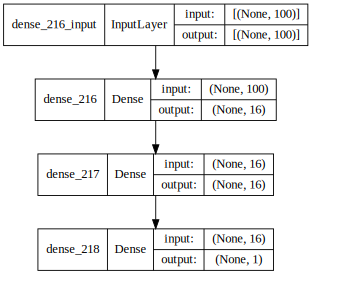

In [15]:
network=models.Sequential() #start neural network

network.add(layers.Dense(units=16,activation="relu",input_shape=(number_of_features,))) 
network.add(layers.Dense(units=16,activation="relu"))
network.add(layers.Dense(units=1,activation="sigmoid")) 

SVG(model_to_dot(network, show_shapes=True, show_layer_names=True, dpi=65).create(prog="dot",format="svg"))

## VIII. Classifying images<a class="anchor" id="Partie8"></a>

### VIII.1. Image classification<a class="anchor" id="Partie8.1"></a>

ConvNets sont un type de réseau très populaire qui ont prouvé leur efficacité dans la computer vision. Il serait possible d'utiliser des réseaux denses ou tous les pixels sont une features mais il y a 2 problèmes. Les réseaux denses ne prennent pas en compte la structure spatiale des pixels. De plus les réseaux denses apprenent de manières globale cela veut dire qu'un objet serait détecté sans prendre en compte sa position dans l'image.

Le pouvoir des réseaux convolutionnels est donc leur habilité de gérer ces 2 problèmes. Une image a 3 dimensions, hauteur, largeur et profondeur (channels) qui représente les canaux de couleur (gris ou RGB). Une convolution peut donc être représentée par une fénètre avec un poid par pixel qui va glisser sur l'image en regardant un pixel individuel ainsi que ses voisins et en réalisant une combinaison linéaire de ces pixels selon les poids appris. La convolution va donner une nouvelle image 3D ou les 2 premières dimensions sont la largeur et la hauteur et la 3eme est le nombre de filtre "filters" utilisé.

Le 2ème concept important ici est la pooling layer qui va permettre de réduire la dimension de l'image "downsizing" en faisant glisser également une fénêtre sur la nouvelle image obtenue (méthode la plus commune est le max pooling qui va prendre le pixel le plus important parmis ceux de la fenêtre). Le pooling permettre de réduire le nombre de paramètre à apprendre. 

Enfin les couches denses sont utilisées pour réaliser la classification.

Le processus ici ets d'utiliser le MNIST dataset (handwritten digit), on va d'abord réorganiser la shape des images pour qu'elle convienne à Keras: NHWC. Ensuite on réechellone les pixels entre 0 et 1 pour ne pas avoir trop de différence entre les pixels car le modèle peut vite donner trop d'importance aux fortes valeurs de pixels. Enfin on one-hot encode les catégories.

On utilise une couche de dropout pour éviter tout sur-apprentissage.
On utilise une couche de flatten pour convertir les images convoluées en un format utilisable pour une couche dense.

In [16]:
from keras import backend
backend.set_image_data_format('channels_last')

np.random.seed(0)

# configuration des informations
channels=1
height=28
width=28

# chargement et reshaping des données
(data_train,target_train),(data_test,target_test)=mnist.load_data()

data_train=data_train.reshape(data_train.shape[0],height,width,channels)
data_test=data_test.reshape(data_test.shape[0],height,width,channels)

# normalisation des pixels
features_train=data_train/255
features_test=data_test/255

# encodage one-hot des labels
target_train=np_utils.to_categorical(target_train)
target_test=np_utils.to_categorical(target_test)
number_of_classes=target_test.shape[1]

# construction du réseau de neurones convolutionnels
network=models.Sequential() 

# couche convolutionnelle avec 64 filtres, chaque filtre est de taille 5x5 et une fonction d'activation ReLU
network.add(Conv2D(filters=64,
                   kernel_size=(5,5),
                   input_shape=(height,width,channels),
                   activation='relu'))

# couche de maxpooling avec un filtre de taille 2x2
network.add(MaxPooling2D(pool_size=(2,2)))

network.add(Dropout(0.5))
network.add(Flatten())
network.add(Dense(128,activation="relu"))
network.add(Dropout(0.5))
network.add(Dense(number_of_classes,activation="softmax"))

network.compile(loss="categorical_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=5, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=1000, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data

Epoch 1/5
60/60 [==============================] - 40s 647ms/step - loss: 0.5909 - accuracy: 0.8156 - val_loss: 0.1832 - val_accuracy: 0.9456
Epoch 2/5
60/60 [==============================] - 38s 627ms/step - loss: 0.1977 - accuracy: 0.9416 - val_loss: 0.0857 - val_accuracy: 0.9740
Epoch 3/5
60/60 [==============================] - 38s 640ms/step - loss: 0.1274 - accuracy: 0.9628 - val_loss: 0.0612 - val_accuracy: 0.9810
Epoch 4/5
60/60 [==============================] - 37s 621ms/step - loss: 0.0987 - accuracy: 0.9716 - val_loss: 0.0505 - val_accuracy: 0.9840
Epoch 5/5
60/60 [==============================] - 43s 712ms/step - loss: 0.0840 - accuracy: 0.9746 - val_loss: 0.0434 - val_accuracy: 0.9858


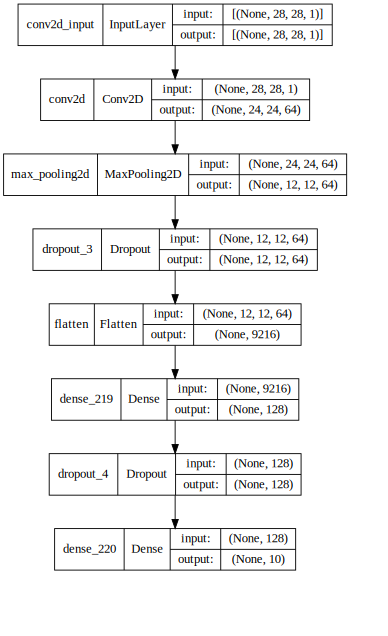

In [17]:

SVG(model_to_dot(network, show_shapes=True, show_layer_names=True, dpi=65).create(prog="dot",format="svg"))

### VIII.2. Improving performance with image augmentation<a class="anchor" id="Partie8.2"></a>

Pour améliorer la performance d'un réseau convolutionnel est de pre-process les images. ImageDataGenerator permet de faire les opérations de bases de standardisation. L'autre méthode est d'ajouter du bruit à l'image en effet cela va rendre le réseau de neurones plus robuste au bruit introduit dans des vrais images et empêche donc le sur-apprentissage sur le set de train. L'ajout de bruit se fait en transformant de manière aléatoire les images en entrée: rotation, zoom, inversion etc... ici flow_from_directory renvoie un generator il faut donc utiliser fit_generator pour entraîner notre réseau sur ces images.

In [18]:
# On crée  l'image augmentation
augmentation = ImageDataGenerator(featurewise_center=True, # ZCA whitening
                                  zoom_range=0.3, # randomly zoom on image
                                  width_shift_range=0.2, # randomly shift image
                                  horizontal_flip=True, # randomly flip image
                                  rotation_range=90) # randomly rotate

augment_images=augmentation.flow_from_directory("raw/images",
                                                batch_size=32,
                                                class_mode="binary",
                                                save_to_dir="processed/images")


# history=network.fit_generator(augment_images, #set de training
#                     steps_per_epoch=2000, #label de training
#                     epochs=5, #nombre d'epoch
#                     verbose=1, #print la description a chaque epoch
#                     batch_size=1000, #nombre d'observation par batch
#                     validation_data=augment_images_test,
#                     validation_steps=8000) #test data


Found 0 images belonging to 0 classes.


## IX. Classifying text<a class="anchor" id="Partie9"></a>

Concernant de la classification de text les réseaux récurrents sont les plus intéressants. En effet l'élément clé de ces réseaux est qu'il y a une "mémoire" pour la gestion de donnée séquentielle comme des phrases. Le type populaire des réseaux récurrents est LSTM (Long Short Term Memory). Ici on revient sur les movie review pour prédire si ces reviews sont négatives ou positives.

On va ici utiliser Layers.Embedding pour obtenir un vecteur propre à chaque mot et ne pas utiliser un one-hot vecteur par mot qui donnerait de moins bons résultats.

In [19]:
np.random.seed(0) #on confidure la random seed
number_of_features=1000 #nombre de features dans le set (ie nombre de mot)

# on utilise le set movie review pour créer le set de train et test afin d'avoir le même nombre de feature par review
(data_train,target_train),(data_test,target_test)=imdb.load_data(num_words=number_of_features) 

# on tronque les observations à 400 features 
features_train=sequence.pad_sequences(data_train,maxlen=400)
features_test=sequence.pad_sequences(data_test,maxlen=400)

network=models.Sequential() #start neural network

network.add(layers.Embedding(input_dim=number_of_features, output_dim=128)) # embedding layer

network.add(layers.LSTM(units=128)) # LSTM with 128 units

network.add(layers.Dense(units=1,activation="sigmoid")) 

network.compile(loss="binary_crossentropy", 
                optimizer="rmsprop", 
                metrics=["accuracy"])

# train neural network

history=network.fit(features_train, #set de training
                    target_train, #label de training
                    epochs=1, #nombre d'epoch
                    verbose=1, #print la description a chaque epoch
                    batch_size=1000, #nombre d'observation par batch
                    validation_data=(features_test,target_test)) #test data

Epoch 1/3
25/25 [==============================] - 418s 16s/step - loss: 0.6988 - accuracy: 0.5999 - val_loss: 0.6551 - val_accuracy: 0.6341
Epoch 2/3
25/25 [==============================] - 387s 16s/step - loss: 0.6167 - accuracy: 0.7020 - val_loss: 0.4754 - val_accuracy: 0.7899
Epoch 3/3
25/25 [==============================] - 527s 21s/step - loss: 0.4971 - accuracy: 0.7695 - val_loss: 0.5763 - val_accuracy: 0.6796


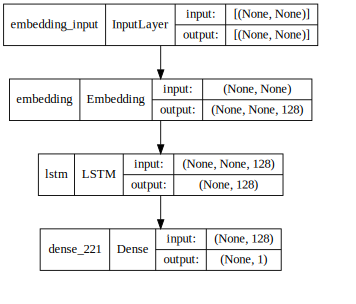

In [20]:
SVG(model_to_dot(network, show_shapes=True, show_layer_names=True, dpi=65).create(prog="dot",format="svg"))

## X. Saving & loading a model<a class="anchor" id="Partie10"></a>

In [22]:
network.save("model_embedding_review.h5")

In [23]:
new_network=load_model("model_embedding_review.h5")